# EDA for BigEarthNet Data

In this notebook, we will attempt to perform EDA to understand the distribution of the class labels in the training and validation data. We will also perform a visualization of the different vegetative and water canopy indices on the images. Some of these indices are taken from the Sentinel2 


In [1]:
IMG_BASE_PATH = '/home/cagastya/hdd/BigEarthNet-v1.0/'
CSV_DIR = 'data'

In [2]:
import sys
import os
import numpy as np
import PIL
import rasterio
from matplotlib import pyplot as plt
import cv2
import pandas as pd
%matplotlib inline
import time
from math import sin, cos, sqrt, atan2, radians
from shapely.geometry import box
from scipy.signal import find_peaks

## 1. Create RGB Bands for Visualization

Lets view the satellite images we download for each ground truth location from crop land and visualize them using their RGB information

In [3]:
# Spectral band names to read related GeoTIFF files
band_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B09',
              'B07', 'B08', 'B8A', 'B11', 'B12']

rgb_names = ['B04', 'B03', 'B02']
ag_names = ['B11', 'B12', 'B8A']
band_combinations = [rgb_names, ag_names]

SCALE_FACTOR = 5000

def plot_band_combs(foldername, base_paths, band_combinations, scale = SCALE_FACTOR):
  '''
  This function is used to visualize a set of images at a fixed latitude 
  and varying longitudes. he function can take multiple band combinations
  which will be plotted as separate rows.
  '''
  imarrays = []
  for comb in band_combinations:
    for base_path in base_paths:
      for b, band_name in enumerate(comb):
        #print(base_path)
        # First finds related GeoTIFF path and reads values as an array
        band_path = os.path.join(foldername, base_path, f'{base_path}_{band_name}.tif')
        band_ds = rasterio.open(band_path)
        raster_band = np.array(band_ds.read(1))
        band_data = np.array(raster_band)
        #print(band_data.shape)
        if b == 0:
            imarray = np.zeros((3404, 2784,3))
        if band_data.shape != imarray.shape[:2]:
            band_data = cv2.resize(band_data, (imarray.shape[1],imarray.shape[0]))
        imarray[:,:,b] = band_data / scale

      imarrays.append(imarray)

  fix, axes = plt.subplots(ncols=len(base_paths),
                            nrows=len(band_combinations),
                            sharex=True,
                            sharey=True,
                            figsize=(4*len(base_paths),6*len(band_combinations)))
  axes = axes.flatten()
  for i, img in enumerate(imarrays):
    axes[i].imshow(img)
  for ax in axes:
    ax.set_axis_off()
        
  plt.subplots_adjust(hspace=0.0,wspace=0.0)

## 2. Labels

First let us look at the labels we have in the dataset.

In [4]:
# Load the labels json file
import json
labels = pd.read_json('label_indices.json')
labels

,original_labels
Agro-forestry areas,21
Airports,5
Annual crops associated with permanent crops,18
Bare rock,30
"Beaches, dunes, sands",29
Broad-leaved forest,22
Burnt areas,32
Coastal lagoons,40
Complex cultivation patterns,19
Coniferous forest,23


In [5]:
labels = labels['original_labels']
labels.head()

Agro-forestry areas                             21
Airports                                         5
Annual crops associated with permanent crops    18
Bare rock                                       30
Beaches, dunes, sands                           29
Name: original_labels, dtype: int64

In [5]:
print(f'Total number of labels: {len(labels)}')

Total number of labels: 43


## 3. Data

Let us look at the label distribution of the data.

### 3.1 Distribution of labels

In [12]:
data = pd.read_csv('big_earth_net_labels.csv', delimiter = ';', header = None)
data.columns = ['patch', 'label']
data.head()

,patch,label
0,S2B_MSIL2A_20170825T093029_16_66,"[""Non-irrigated arable land"",""Complex cultivat..."
1,S2A_MSIL2A_20170717T113322_34_77,"[""Non-irrigated arable land"",""Pastures"",""Broad..."
2,S2B_MSIL2A_20171016T101009_64_45,"[""Sea and ocean""]"
3,S2B_MSIL2A_20170830T102019_74_55,"[""Sea and ocean""]"
4,S2A_MSIL2A_20171002T112112_77_62,"[""Broad-leaved forest"",""Sclerophyllous vegetat..."


In [17]:
import ast
from collections import defaultdict

counts = defaultdict(int)

# Load the training data counts
def tallyLabelCounts(labels):
    for lbl in labels:
        counts[lbl] += 1      

# See how many of these include a multi-class label
data.label.apply(lambda x: tallyLabelCounts(ast.literal_eval(x)))
counts

defaultdict(int,
            {'Non-irrigated arable land': 196695,
             'Complex cultivation patterns': 107786,
             'Land principally occupied by agriculture, with significant areas of natural vegetation': 147095,
             'Broad-leaved forest': 150944,
             'Pastures': 103554,
             'Peatbogs': 23207,
             'Sea and ocean': 81612,
             'Sclerophyllous vegetation': 11241,
             'Agro-forestry areas': 30674,
             'Transitional woodland/shrub': 173506,
             'Industrial or commercial units': 12895,
             'Discontinuous urban fabric': 69872,
             'Construction sites': 1174,
             'Vineyards': 9567,
             'Sport and leisure facilities': 5353,
             'Permanently irrigated land': 13589,
             'Fruit trees and berry plantations': 4754,
             'Water bodies': 83811,
             'Coniferous forest': 211703,
             'Mixed forest': 217119,
             'Continuous urban

In [42]:
total = data.shape[0]
total

590326

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42],
 <a list of 43 Text xticklabel objects>)

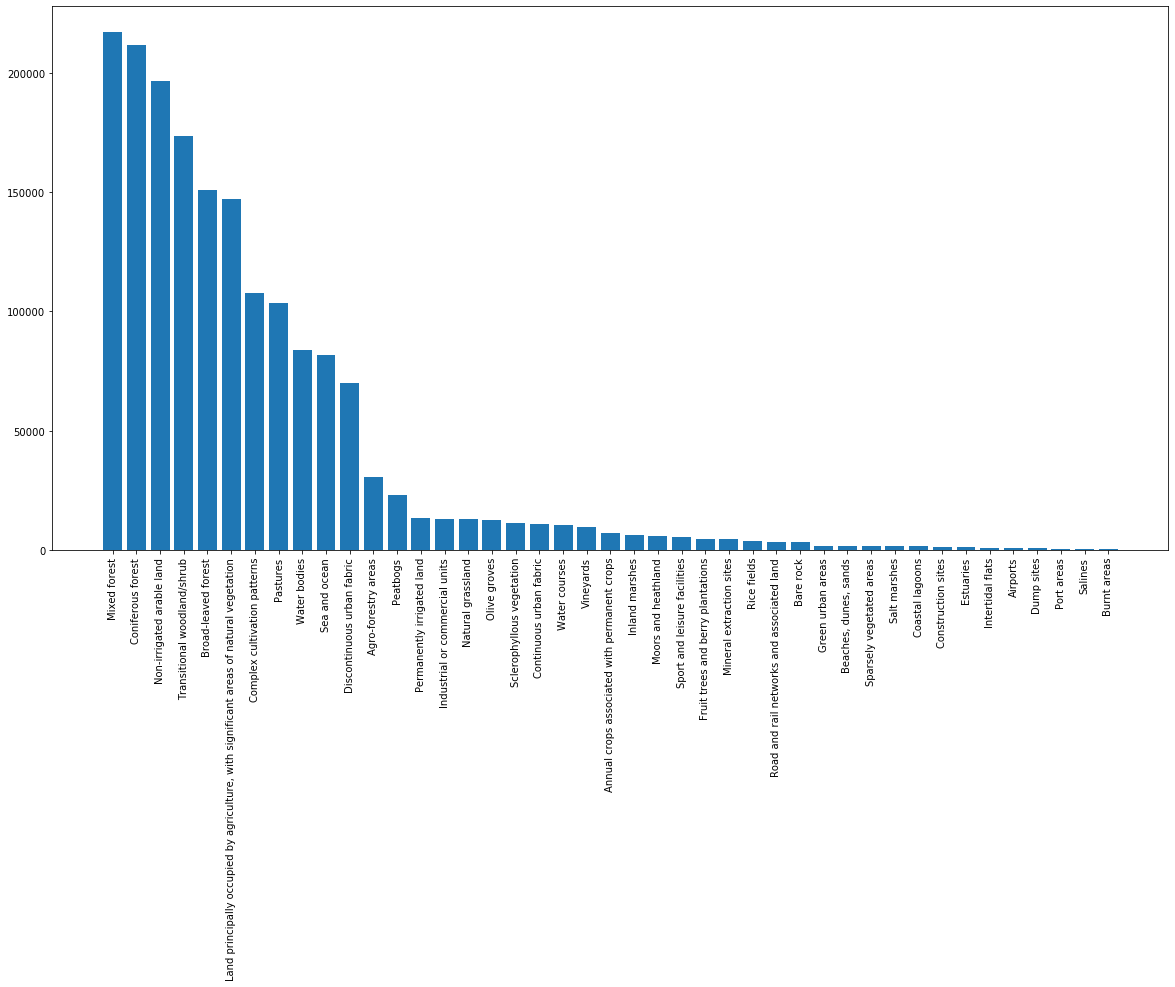

In [28]:
lbls = sorted(counts.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(20,10))
plt.bar([x[0] for x in lbls], [x[1] for x in lbls])
plt.xticks(rotation='vertical')

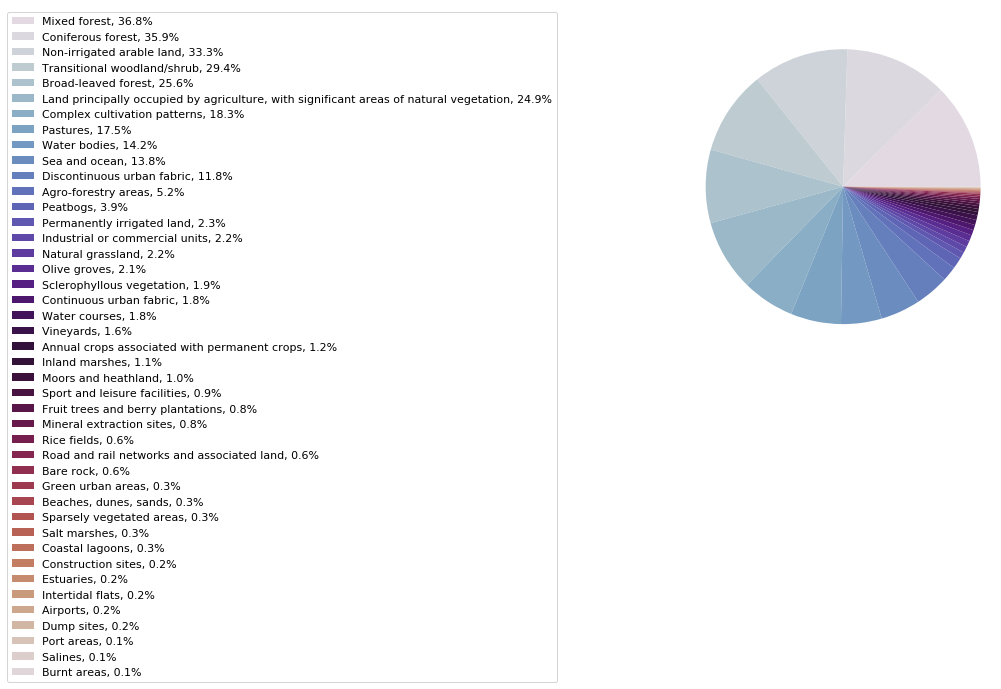

In [37]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
#sizes = [15, 30, 45, 10]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)
theme = plt.get_cmap('twilight')
ax1.set_prop_cycle("color", [theme(1. * i / len(counts)) for i in range(len(counts))])
ax1.pie([x[1] for x in lbls])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend(
    loc='upper right',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip([x[0] for x in lbls], [x[1] for x in lbls])],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

### 3.2. Single Vs Multi Class Patches

Based on the output above, we can see that even though there are only 269695 actual patch images in the training directory, we see a total of 806960 image labels. This is because BigEarthNet is a multilabel data where there are many instances where an image has been assigned more than 1 labels. We can also see that the training data includes all the labels. Now lets see of these images, how many belong to a single class vs multiclass

In [38]:
import ast
# See how many of these include a multi-class label
data['Length'] = data.label.apply(lambda x: len(ast.literal_eval(x)))
data.head(10)


,patch,label,Length
0,S2B_MSIL2A_20170825T093029_16_66,"[""Non-irrigated arable land"",""Complex cultivat...",4
1,S2A_MSIL2A_20170717T113322_34_77,"[""Non-irrigated arable land"",""Pastures"",""Broad...",4
2,S2B_MSIL2A_20171016T101009_64_45,"[""Sea and ocean""]",1
3,S2B_MSIL2A_20170830T102019_74_55,"[""Sea and ocean""]",1
4,S2A_MSIL2A_20171002T112112_77_62,"[""Broad-leaved forest"",""Sclerophyllous vegetat...",2
5,S2A_MSIL2A_20170813T112121_46_80,"[""Non-irrigated arable land"",""Agro-forestry ar...",3
6,S2B_MSIL2A_20180422T093029_60_71,"[""Industrial or commercial units"",""Complex cul...",3
7,S2B_MSIL2A_20170831T095029_19_7,"[""Discontinuous urban fabric"",""Construction si...",4
8,S2B_MSIL2A_20180220T114339_47_49,"[""Sport and leisure facilities"",""Non-irrigated...",3
9,S2B_MSIL2A_20170914T093029_26_42,"[""Non-irrigated arable land"",""Broad-leaved for...",3


In [39]:
single_class = data[data['Length'] == 1].shape[0]
multi_class = data[data['Length'] > 1].shape[0]
print(f'Number of patches belonging to a single class: {single_class}')
print(f'Number of patches belonging to multiple class: {multi_class}')
print(f'Total Sum: {single_class + multi_class}')

Number of patches belonging to a single class: 114073
Number of patches belonging to multiple class: 476253
Total Sum: 590326


In [41]:
# Check how many of these strictly belong to just permanent irrigated land
PATTERN = 'Permanently irrigated land'
pil_s = data[data['Length'] == 1 & data['label'].str.contains(PATTERN)]
print(f'Patches that only belong to Permanently Irrigated Land label: {pil_s.shape[0]}')

# Check how many belong to the multi class
pil_m = data[(data['label'].str.contains(PATTERN)) & (data['Length'] > 1 )]
print(f'Patches that belong to Permanently Irrigated Land label for mlti class: {pil_m.shape[0]}')

# Check in all how many belong to permanently irrigated land
total_irr = data[data['label'].str.contains(PATTERN)].shape[0]
print(f'Total images belonging to permanently irrigated land label: {total}')

Patches that only belong to Permanently Irrigated Land label: 227
Patches that belong to Permanently Irrigated Land label for mlti class: 13362
Total images belonging to permanently irrigated land label: 13589


In [43]:
print(f'Pecentage of data belonging to irrigated land: {(total_irr/total) * 100}')

Pecentage of data belonging to irrigated land: 2.3019484149436074


## 3.3 Permanently Irrigated Data

Our reading of the literature shows that vineyards, olive grows, fruit orchards and rice fields are among those that are permanently irrigated but not necessarily marked in that class. So let's see how much overlap exists between these sets of labels 

In [48]:
other_irr_labels = ['Fruit trees and berry plantations', 'Rice fields', 'Vineyards', 'Olive groves']

def statsForOtherIrrLands(arr):
    for lbl in arr:
        cnt1 = data[data['label'].str.contains(lbl) & data['label'].str.contains(PATTERN)].shape[0]
        cnt2 = data[data['label'].str.contains(lbl) & (data['label'].str.contains(PATTERN) == False)].shape[0]
        print(f'Images with "{lbl}" that are also "{PATTERN}": {cnt1}')
        print(f'Images with "{lbl}" that are not "{PATTERN}": {cnt2}')
        
print(f'Statistics for other permanently irrigated cropland that are not included in "{PATTERN}"')
print('-' * 100)
statsForOtherIrrLands(other_irr_labels)

Statistics for other permanently irrigated cropland that are not included in "Permanently irrigated land"
----------------------------------------------------------------------------------------------------
Images with "Fruit trees and berry plantations" that are also "Permanently irrigated land": 445
Images with "Fruit trees and berry plantations" that are not "Permanently irrigated land": 4309
Images with "Rice fields" that are also "Permanently irrigated land": 1504
Images with "Rice fields" that are not "Permanently irrigated land": 2289
Images with "Vineyards" that are also "Permanently irrigated land": 1377
Images with "Vineyards" that are not "Permanently irrigated land": 8190
Images with "Olive groves" that are also "Permanently irrigated land": 2770
Images with "Olive groves" that are not "Permanently irrigated land": 9768


In [50]:
total_irrigated = data[data['label'].str.contains('Fruit trees and berry plantations') | \
                      data['label'].str.contains('Rice fields') | \
                      data['label'].str.contains('Vineyards') | \
                      data['label'].str.contains('Olive groves') | \
                      data['label'].str.contains(PATTERN)].shape[0] 
print(f'Total irrigated land: {total_irrigated}')
print(f'% Total irrigated land: {total_irrigated/total * 100}')                                              

Total irrigated land: 36686
% Total irrigated land: 6.2145323092664055


In [51]:
# Other possible categories
statsForOtherIrrLands(['Annual crops associated with permanent crops',
                       'Complex cultivation patterns',
                       'Pastures'])

Images with "Annual crops associated with permanent crops" that are also "Permanently irrigated land": 706
Images with "Annual crops associated with permanent crops" that are not "Permanently irrigated land": 6316
Images with "Complex cultivation patterns" that are also "Permanently irrigated land": 3609
Images with "Complex cultivation patterns" that are not "Permanently irrigated land": 104177
Images with "Pastures" that are also "Permanently irrigated land": 2218
Images with "Pastures" that are not "Permanently irrigated land": 101336


### 1. Irrigated Data

In [52]:
base_paths = pil_s['patch'].head(4)
base_paths = base_paths.tolist()
base_paths

['S2A_MSIL2A_20170704T112111_14_62',
 'S2A_MSIL2A_20171221T112501_7_68',
 'S2A_MSIL2A_20171121T112351_32_34',
 'S2A_MSIL2A_20171221T112501_33_35']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


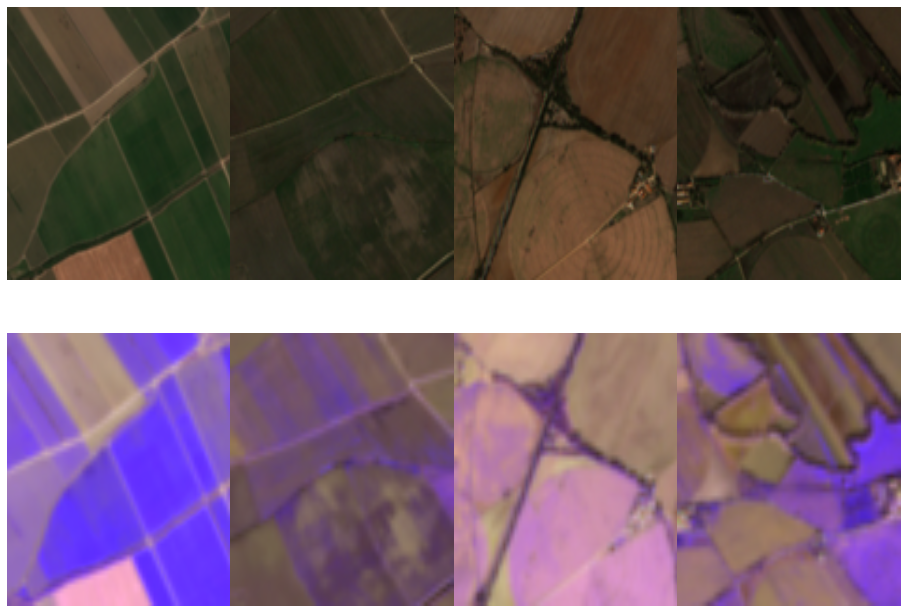

In [53]:
# Call the plot function
plot_band_combs(IMG_BASE_PATH, base_paths, band_combinations)

### 2. Not Irrigated

['S2B_MSIL2A_20170825T093029_16_66', 'S2A_MSIL2A_20170717T113322_34_77', 'S2B_MSIL2A_20171016T101009_64_45', 'S2B_MSIL2A_20170830T102019_74_55']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


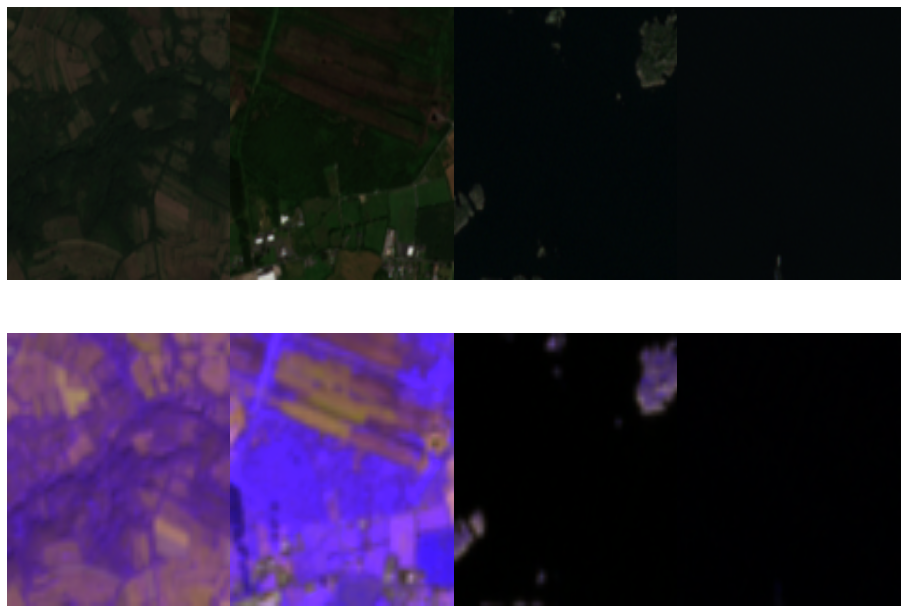

In [54]:
base_paths = data[(data['label'].str.contains(PATTERN)) == False].head(4)
base_paths = base_paths['patch'].tolist()
print(base_paths)

# Call the plot function (these appear to be pastures)
plot_band_combs(IMG_BASE_PATH, base_paths, band_combinations)

## Vegetative Indices

We are interested in seeing the enhanced vegetative index (EVI), soil adjusted vegetative index (SAVI), Moisture stress index (MSI) etc. of these locations

$EVI = 2.5(NIR - Red)/(NIR + 6 * Red - 7.5 * Blue + 1)$

$SAVI = (1 + L)(NIR - Red)/(NIR + Red + L)$ where L = 0.5 (canopy background adjustment factor)

- Moisture Stress Index: This index is a reflectance measurement that is sensitive to increasing leaf water content. As the water content of leaves in vegetation canopies increases, the strength of the absorption around 1599 nm increases. Absorption at 819 nm is nearly unaffected by changing water content, so it is used as the reference. Applications include canopy stress analysis, productivity prediction and modeling, fire hazard condition analysis, and studies of ecosystem physiology. The MSI is inverted relative to the other water VIs; higher values indicate greater water stress and less water content. 

$MSI = MidIR/ NIR$ or here we use SWIR (band 11)/NIR (band 8)

- Normalized Difference Infrared Index: This index is a reflectance measurement that is sensitive to changes in water content of plant canopies. The NDII uses a normalized difference formulation instead of a simple ratio, and the index values increase with increasing water content. Applications include crop agricultural management, forest canopy monitoring, and vegetation stress detection.

$NDII = (NIR - MIR)/ (NIR + MIR)$

- Normalized Multi-band Drought Index (NMDI): This index takes into account a soil moisture background to monitor potential drought conditions. Three specific bands were chosen because of their unique response to variations in soil and vegetation moisture. The index uses the difference between two liquid-water absorption bands in the shortwave-infrared region (1640 and 2130 nm) as a measure of water sensitivity in vegetation and soil. This index is also commonly used in forest-fire detection.

As soil moisture increases, the index values decrease. Index values range from 0.7 to 1 for dry soil, 0.6 to 0.7 for soil with intermediate moisture, and less than 0.6 for wet soil.

$NMDI = (NIR - (SWIR1 - SWIR2)) / (NIR + (SWIR1 - SWIR2))$

- Water Band Index (WBI): This index is a reflectance measurement that is sensitive to changes in canopy water status. As the water content of vegetation canopies increases, the strength of the absorption around 970 nm increases relative to that of 900 nm. Applications include canopy stress analysis, productivity prediction and modeling, fire hazard condition analysis, cropland management, and studies of ecosystem physiology.

$WBI = Band-9 / Band-8A $


In [102]:
import matplotlib as mpl
from rasterio.enums import Resampling

def get_band_data(band_path, sf = 1):
  band_ds = rasterio.open(band_path)
  if sf == 1:
      raster_band = np.array(band_ds.read(1))
  else:
    #resample bands that need to be upscaled
    raster_band = np.array(band_ds.read(
            out_shape=(int(band_ds.height * sf),int(band_ds.width * sf)),
            resampling=Resampling.bilinear)).reshape(120,120)
  return np.array(raster_band)

def plot_vegetative_moisture_index(folderpath, base_paths, index, scale = SCALE_FACTOR):
    imarrays = []
    nrows, ncols = np.shape(base_paths)
    
    assert(index in 'EVI SAVI NDII NMDI MSI NDWI'.split())
    
    # Enhanced Vegetative Index
    if index == 'EVI':
      color_map = 'RdYlGn'
      for row in base_paths:
        for base_path in row:
            # First finds related GeoTIFF path and reads values as an array
            nir_data = get_band_data(os.path.join(folderpath, base_path,f'{base_path}_B08.tif'))
            red_data = get_band_data(os.path.join(folderpath, base_path,f'{base_path}_B04.tif'))
            blue_data = get_band_data(os.path.join(folderpath, base_path,f'{base_path}_B02.tif'))

            # Since the blue band is only added to decrease noise this variant of EVI called EVI2 
            # serves as a good proxy indicator for EVI 
            # -- dual band EVI2
            imarray = 2.5 * ((nir_data - red_data) / (nir_data + (2.4 * red_data) + 1))
            imarrays.append(imarray)
    
    # Soil Adjusted Vegetative Index
    elif index == 'SAVI':
      color_map = 'RdYlGn'
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B08.tif'))
            red_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B04.tif'))
                        
            imarray = 1.5*(nir_data-red_data) / (nir_data + red_data + 0.5)
            imarrays.append(imarray)
            
    # Moisture Stress Index
    elif index == 'MSI':
      color_map = 'RdYlBu_r' #mpl.cm.Blues
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B8A.tif'))
            sw1_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B11.tif'))
            
            # --- Moisture Index
            imarray = (nir_data - sw1_data)/ (nir_data + sw1_data)
            imarrays.append(imarray)
            
    #Normalized diff water index
    elif index == 'NDWI':
      color_map = 'RdYlBu_r' #mpl.cm.Blues
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B08.tif'))
            gr_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B03.tif'))
                        
            imarray = (gr_data - nir_data)/ (gr_data + nir_data)
            imarrays.append(imarray)
    
    elif index == 'NMDI':
      color_map = 'BrBG' #mpl.cm.Blues
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B08.tif'))
            sw1_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B11.tif'), 2)
            sw2_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B12.tif'), 2)
            print(sw1_data.shape())
            
            imarray = (nir_data - (sw1_data - sw2_data))/ (nir_data + (sw1_data + sw2_data))
            imarrays.append(imarray)
    
    # --- Normalized Difference Infrared Index
    elif index == 'NDII':
      color_map = 'BrBG' #mpl.cm.Blues
      for row in base_paths:
        for base_path in row:
            nir_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B08.tif'))
            mir_data = get_band_data(os.path.join(folderpath,base_path, f'{base_path}_B11.tif'), 2)
            
            imarray = (nir_data - mir_data)/ (nir_data + mir_data)
            imarrays.append(imarray)
    
    

    fix, axes = plt.subplots(ncols=ncols,
                             nrows=nrows,
                             sharex=True,
                             sharey=True,
                             figsize=(4*ncols,6*nrows))
    axes = axes.flatten()
    for i, img in enumerate(imarrays):
        im = axes[i].imshow(img, cmap=color_map)

    for ax in axes:
        ax.set_axis_off()

    # Colorbar
    fix.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75, pad = 0.05)
        
    plt.subplots_adjust(hspace=0.1,wspace=0.1)
    ret = [np.nanmedian(x) for x in imarrays]
    print(ret)
    return ret
    
    

### 1. Irrigated Data

[1.1658315434102873, 0.6557547533213663, 0.35087867352861557, 0.7413404391257425]
[0.8965171211795602, 0.5651273053938083, 0.32588495236762627, 0.6262134431179389]
[0.38070311575295945, 15.603380736535705, 9.683502307971072, 12.676591487063487]
[12.02572783879134, 24.083364171582154, 15.95353150643091, 22.204616845053042]


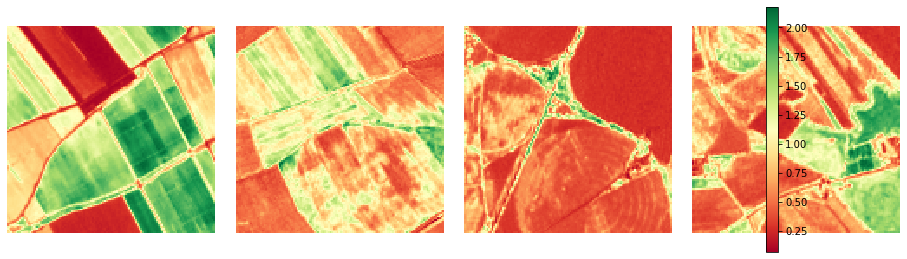

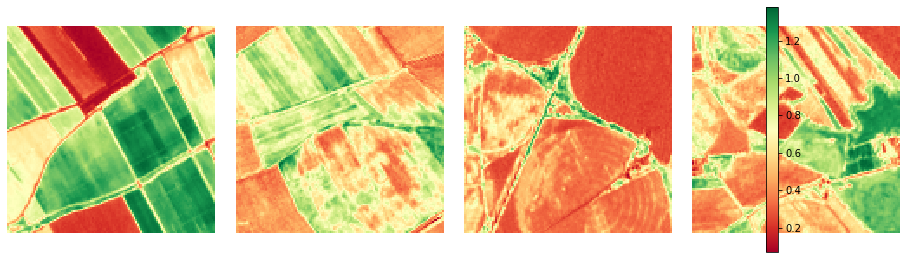

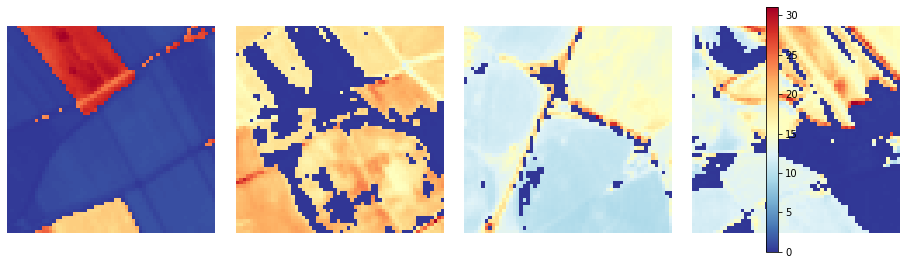

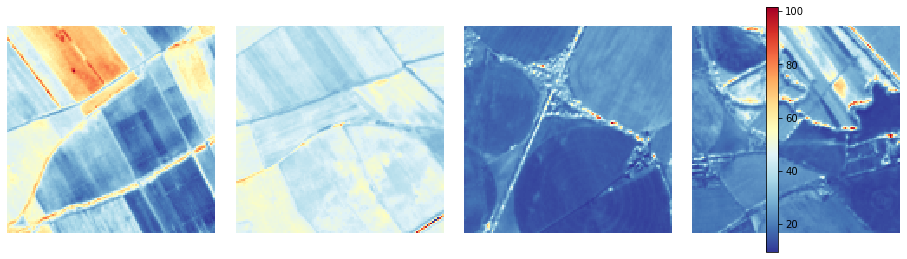

In [96]:
base_paths = [['S2A_MSIL2A_20170704T112111_14_62',
 'S2A_MSIL2A_20171221T112501_7_68',
 'S2A_MSIL2A_20171121T112351_32_34',
 'S2A_MSIL2A_20171221T112501_33_35']]

evi2 = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'EVI')
savi = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'SAVI')
msi = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'MSI')
ndwi = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'NDWI')

           EVI      SAVI       MSI      NDWI
EVI   1.000000  0.997912 -0.670314 -0.396089
SAVI  0.997912  1.000000 -0.621881 -0.336602
MSI  -0.670314 -0.621881  1.000000  0.946170
NDWI -0.396089 -0.336602  0.946170  1.000000


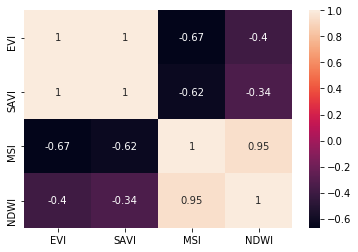

In [99]:
# Compute correlation matrix for these readings
import seaborn as sn
import matplotlib.pyplot as plt

data = {'EVI': evi2,
        'SAVI': savi,
        'MSI': msi,
        'NDWI' : ndwi
        }

df = pd.DataFrame(data,columns=['EVI','SAVI','MSI', 'NDWI'])
df.head()
corrMatrix = df.corr()
print (corrMatrix)
sn.heatmap(corrMatrix, annot=True)
plt.show()


### 2. Not Irrigated data

[1.5501285446529929, 1.894393889109434, 1488.4545454545455, 613.2584269662922]
[1.1026077160603776, 1.2626001605892663, 2026.020618556701, 709.3212996389892]
[0.22229274220123024, 0.39373325184912833, 32.877385702616564, 0.4117647058823529]
[21.286433011577234, 14.429181174120743, 0.9851851851851852, 0.5614973262032086]


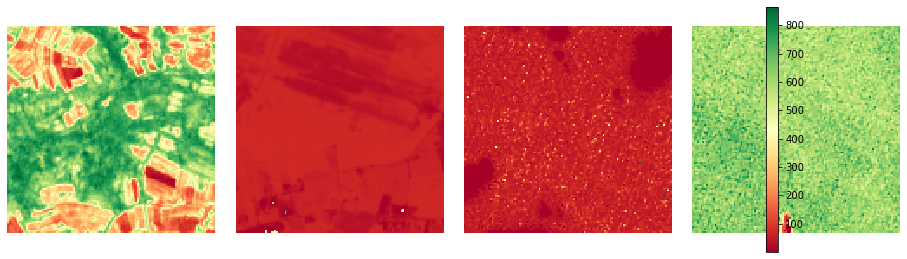

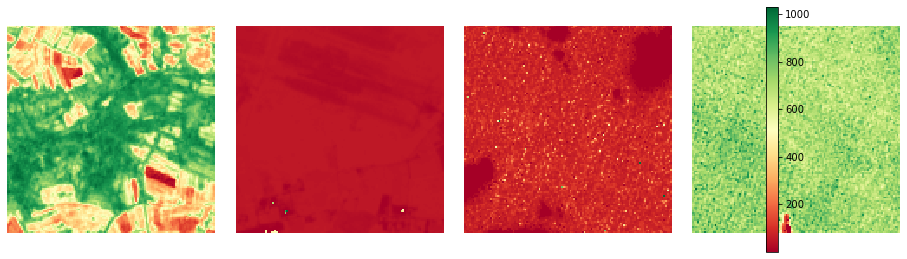

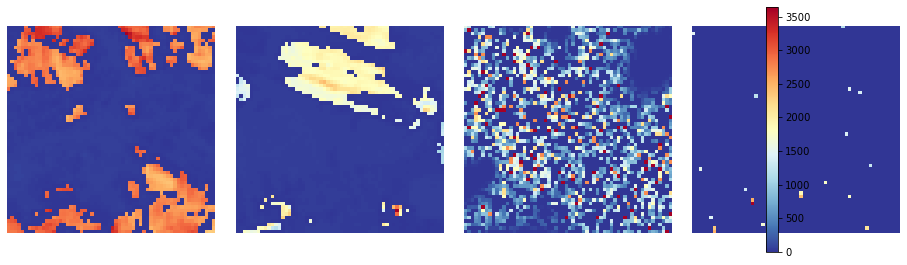

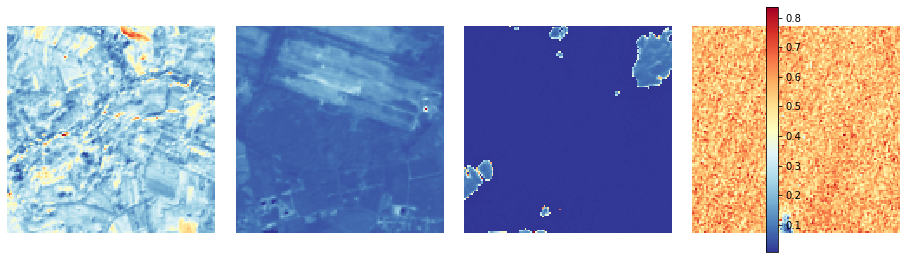

In [100]:
base_paths = [['S2B_MSIL2A_20170825T093029_16_66', 'S2A_MSIL2A_20170717T113322_34_77', 
               'S2B_MSIL2A_20171016T101009_64_45', 'S2B_MSIL2A_20170830T102019_74_55']]
evi2 = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'EVI')
savi = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'SAVI')
msi = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'MSI')
ndwi = plot_vegetative_moisture_index(IMG_BASE_PATH, base_paths, 'NDWI')

           EVI      SAVI       MSI      NDWI
EVI   1.000000  0.997878  0.913338 -0.819958
SAVI  0.997878  1.000000  0.937910 -0.785419
MSI   0.913338  0.937910  1.000000 -0.545121
NDWI -0.819958 -0.785419 -0.545121  1.000000


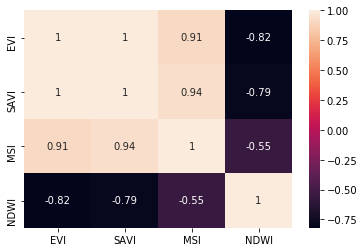

In [101]:
# Compute correlation matrix for these readings
import seaborn as sn
import matplotlib.pyplot as plt

data = {'EVI': evi2,
        'SAVI': savi,
        'MSI': msi,
        'NDWI' : ndwi
        }

df = pd.DataFrame(data,columns=['EVI','SAVI','MSI', 'NDWI'])
df.head()
corrMatrix = df.corr()
print (corrMatrix)
sn.heatmap(corrMatrix, annot=True)
plt.show()
